<a href="https://colab.research.google.com/github/ReillyOareVT/HydroLearners_Proj/blob/main/xai/mean_reg/xai_mean_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainability for XGBoost Mean Regression
**Name:** Emma Reilly Oare
<br>**Date:** May 6, 2025
<br>**Purpose:** XAI techniques for the XGBoost model used to predict mean daily streamflow.

In [1]:
# Read in libs
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
import warnings
from sklearn.pipeline import Pipeline
import shap
import re

# Suppress warnings
warnings.filterwarnings("ignore")

## Step 1. Read in Data

In [2]:
# Only clone if the repo doesn't already exist
if not os.path.exists('/content/HydroLearners_Proj'):
    !git clone https://github.com/ReillyOareVT/HydroLearners_Proj

# Change directory
BASE_DIR = '/content/HydroLearners_Proj'
os.chdir(BASE_DIR)

# Confirm location
!pwd

Cloning into 'HydroLearners_Proj'...
remote: Enumerating objects: 359, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 359 (delta 94), reused 37 (delta 37), pack-reused 175 (from 1)
Receiving objects: 100% (359/359), 117.15 MiB | 12.12 MiB/s, done.
Resolving deltas: 100% (130/130), done.
Updating files: 100% (73/73), done.
/content/HydroLearners_Proj


In [3]:
# Define paths
model_path = os.path.join(BASE_DIR, 'xai', 'models_and_data', 'mean_reg', 'xgboost_model.pkl')
train_test_path = os.path.join(BASE_DIR, 'xai', 'models_and_data', 'mean_reg', 'xgb_train_test.pkl')

# Load in model/data
xgb_model = joblib.load(model_path)
X_train, X_test, y_train, y_test = joblib.load(train_test_path)

## Step 2. Metric Evaluations

In [4]:
# Create predictions
xgb_pred = xgb_model.predict(X_test)
y_test_np = y_test.to_numpy().reshape(-1)
xgb_residuals = y_test_np - xgb_pred.flatten()

# Inverse log transform for additional analysis
pred_orig = np.exp(xgb_pred)
y_test_orig = np.exp(y_test_np)
residual_orig = np.exp(xgb_residuals)

# Display residual shape
xgb_residuals.shape

(2685,)

In [5]:
# Print residual statistics (log)
print("The maximum residual is", round(np.abs(xgb_residuals).max(), 4), "mm/day (log) mean daily streamflow.")
print("The median residual is", round(np.median(np.abs(xgb_residuals)), 4), "mm/day (log) mean daily streamflow.")
print("The minimum residual is", round(np.abs(xgb_residuals).min(), 4), "mm/day (log) mean daily streamflow.")

The maximum residual is 2.9286 mm/day (log) mean daily streamflow.
The median residual is 0.1596 mm/day (log) mean daily streamflow.
The minimum residual is 0.0001 mm/day (log) mean daily streamflow.


In [6]:
# Print residual statistics (original)
print("The maximum residual is", round(np.abs(residual_orig).max(), 4), "mm/day (original) mean daily streamflow.")
print("The median residual is", round(np.median(np.abs(residual_orig)), 4), "mm/day (original) mean daily streamflow.")
print("The minimum residual is", round(np.abs(residual_orig).min(), 4), "mm/day (original) mean daily streamflow.")

The maximum residual is 18.7015 mm/day (original) mean daily streamflow.
The median residual is 1.0109 mm/day (original) mean daily streamflow.
The minimum residual is 0.0589 mm/day (original) mean daily streamflow.


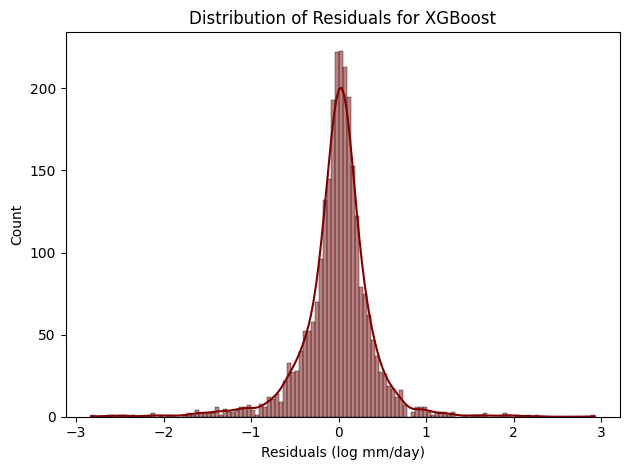

In [7]:
# Plot residuals distribution to check for Gaussian distribution
sns.histplot(xgb_residuals, kde=True, color = 'maroon', alpha = 0.5)
plt.xlabel('Residuals (log mm/day)')
plt.title('Distribution of Residuals for XGBoost')
plt.tight_layout()

# Save to results folder
resid_hist_path = os.path.join(BASE_DIR, 'xai', 'figures', 'XGBoost_resid_hist.png')
plt.savefig(resid_hist_path, dpi = 400)

# Show plot
plt.show()

## Step 3. Explainability

### Step 3a. Feature Importance
We are going to plot three different feature importances:
1. **Weight:** The percentage representing the relative number of times a particular feature occurs in the trees (ex. if feature1 occurred in 2 splits, 1 split and 3 splits in each of tree1, tree2 and tree3; then the weight for feature1 will be 2+1+3 = 6)
2. **Gain:** The improvement in accuracy brought by a feature to the branches it is on. The idea is that before adding a new split on a feature X to the branch there was some wrongly classified elements, after adding the split on this feature, there are two new branches, and each of these branch is more accurate.
3. **Cover:** The relative number of observations related to a feature (ex. if you have 100 observations, 4 features and 3 trees, and suppose feature1 is used to decide the leaf node for 10, 5, and 2 observations in tree1, tree2 and tree3 respectively; then the metric will count cover for this feature as 10+5+2 = 17)
<br><br> The above definitions are found directly from https://medium.com/towards-data-science/be-careful-when-interpreting-your-features-importance-in-Gradient-Boosting-Regressor-6e16132588e7

In [8]:
# ---- Create importance type df ------

importance_types = ['weight', 'gain', 'cover']

# Create booster
xgb_step = xgb_model.named_steps['xgb']
booster = xgb_step.get_booster()

# Pull importances from booster
importances = {
    imp: booster.get_score(importance_type=imp)
    for imp in importance_types
}

# Create feature df
importance_df = pd.DataFrame(importances).fillna(0)
importance_df.index.name = 'feature'
importance_df = importance_df.reset_index()

In [21]:
# List original columns
original_cols = [
    'Ratio of PET/Precipitation',
    'Days/Year of Low Precipitation',
    'Mean Terrain Slope (Degrees)',
    'Depth to Bedrock',
    'Mean Aug NDVI',
    'Mean Leaf-Area Index',
    'Mean % Soil Organic Material',
    'Min Elevation (m)',
    'Mean % Gravel in Soil',
    'Mean NDVI',
    'Mean Soil Bulk Density (g/cm3)',
    'Fraction of Snow on Days <0 C',
    'Mean Root Depth (cm)',
    '% Unconsolidated Sediments',
    'Days/Year with No Flow',
    '% Metamorphics',
    'Stream Density (1000km/km2)',
    'Lithological Dominant Class (Grouped)',
]

#  feature groups
quantile_features = [
    'Ratio of PET/Precipitation',
    'Days/Year of Low Precipitation',
    'Mean Terrain Slope (Degrees)',
    'Depth to Bedrock',
    'Mean Aug NDVI',
    'Mean Leaf-Area Index',
    'Mean % Soil Organic Material',
    'Min Elevation (m)',
    'Mean % Gravel in Soil',
    'Mean NDVI',
    'Mean Soil Bulk Density (g/cm3)',

]
sqrt_features = ['Fraction of Snow on Days <0 C']
cat_cols = ['Lithological Dominant Class (Grouped)']

# Build the suffixed‐name list
suffixed = []
for col in original_cols:
    if col in quantile_features:
        suffixed.append(f"{col} (QN)")
    elif col in sqrt_features:
        suffixed.append(f"{col} (sqrt)")
    else:
        suffixed.append(col)

# Map f# --> suffixed name
f2name = { f"f{i}": suffixed[i] for i in range(len(suffixed)) }

# Remap df
importance_df['feature'] = importance_df['feature'].map(f2name)
importance_df = importance_df.dropna(subset=['feature'])

# Sum up duplicates just in case
importance_df = (
    importance_df
    .groupby('feature', as_index=False)
    .sum()
)

importance_df

,feature,weight,gain,cover
0,% Metamorphics,2612.0,0.365052,214.833466
1,% Unconsolidated Sediments,3146.0,0.533172,397.657990
2,Days/Year of Low Precipitation (QN),5565.0,1.206017,338.298126
3,Days/Year with No Flow,2693.0,1.137801,637.666565
4,Depth to Bedrock (QN),4831.0,0.695866,334.753479
5,Fraction of Snow on Days <0 C (sqrt),4955.0,0.678867,496.250854
6,Lithological Dominant Class (Grouped),347.0,0.561436,177.936600
7,Mean % Gravel in Soil (QN),5106.0,0.406115,370.538391
8,Mean % Soil Organic Material (QN),5300.0,0.448574,341.014893
9,Mean Aug NDVI (QN),5142.0,0.656263,520.105408


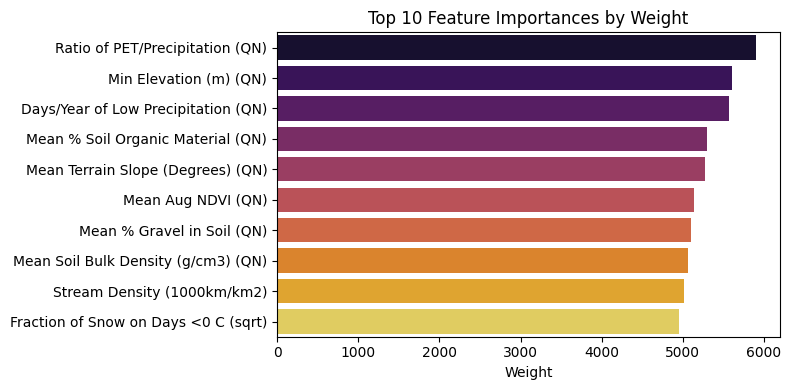

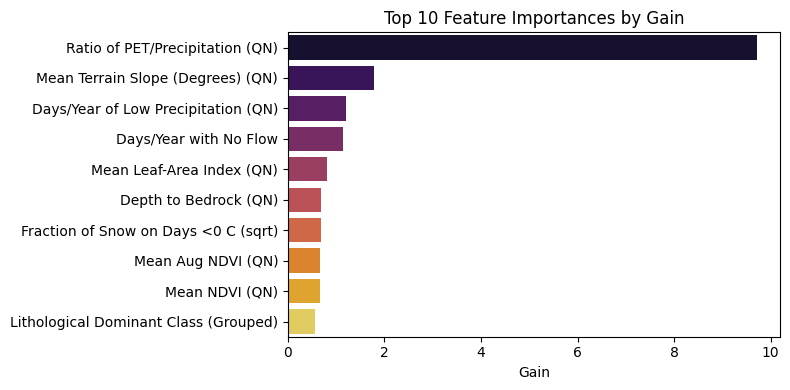

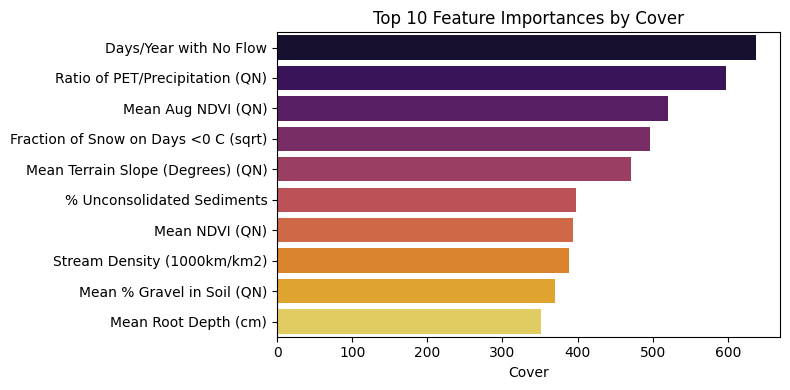

In [22]:
top_n = 10

for imp in importance_types:
    # Select the top_n features and sort ascending for better horizontal plotting
    df_top = (importance_df
              .nlargest(top_n, imp)
              .sort_values(by=imp, ascending=False))

    plt.figure(figsize=(8, 4))
    sns.barplot(
        x=imp,
        y='feature',
        data=df_top,
        palette='inferno'
    )
    plt.title(f'Top {top_n} Feature Importances by {imp.capitalize()}')
    plt.xlabel(imp.capitalize())
    plt.ylabel('')
    plt.tight_layout()

    # Save the figure
    feat_imp_path = os.path.join(BASE_DIR, 'xai', 'figures')
    plt.savefig(os.path.join(feat_imp_path, f"feature_importance_{imp}.png"), dpi=400, bbox_inches='tight')
    plt.show()


### Step 3b. SHAP Values

In [23]:
# Grab fitted steps
preproc  = xgb_model.named_steps['preproc']
xgb_step = xgb_model.named_steps['xgb']

# Transform X_test
X_test_num = preproc.transform(X_test)

# Rebuild the raw post-transform names
feat_names = []
for name, transformer, cols in preproc.transformers_:
    if name in ('quantile', 'sqrt', 'pass'):
        feat_names.extend(cols)
    elif name == 'onehot':
        feat_names.extend(transformer.get_feature_names_out(cols))

# Remove funny stuff
clean_names = [
    re.sub(r'[\[\]<]', '_', fn)
    for fn in feat_names
]

# Build a DataFrame so SHAP sees the right names
X_test_df = pd.DataFrame(X_test_num, columns=clean_names)

# Explain!
explainer   = shap.TreeExplainer(xgb_step.get_booster())
shap_values = explainer.shap_values(X_test_df)

In [24]:
# Rename for plotting
X_shap = X_test_df.copy()
X_shap = X_shap.rename(columns = {
    'Ratio of PET/Precipitation':'Ratio of PET/Precipitation (QN)',
    'Days/Year of Low Precipitation':'Days/Year of Low Precipitation (QN)',
    'Mean Terrain Slope (Degrees)':'Mean Terrain Slope (QN)',
    'Depth to Bedrock':'Depth to Bedrock (QN)',
    'Mean Aug NDVI':'Mean Aug NDVI (QN)',
    'Mean Leaf-Area Index':'Mean Leaf-Area Index (QN)',
    'Mean % Soil Organic Material':'Mean % Soil Organic Material (QN)',
    'Min Elevation (m)':'Min Elevation (QN)',
    'Mean % Gravel in Soil':'Mean % Gravel in Soil (QN)',
    'Mean NDVI':'Mean NDVI (QN)',
    'Mean Soil Bulk Density (g/cm3)':'Mean Soil Bulk Density (QN)',
    'Fraction of Snow on Days _0 C':'Fraction of Snow on Days <0 C (SQRT)',
    'Lithological Dominant Class (Grouped)_Acid Plutonic':'Acid Plutonic',
    'Lithological Dominant Class (Grouped)_Carbonate Sedimentary':'Carbonate Sedimentary',
    'Lithological Dominant Class (Grouped)_Metamorphics':'Metamorphics',
    'Lithological Dominant Class (Grouped)_Mixed Sedimentary':'Mixed Sedimentary',
    'Lithological Dominant Class (Grouped)_Other':'Other',
    'Lithological Dominant Class (Grouped)_Siliciclastic Sedimentary':'Siliciclastc Sedimentary',
    'Lithological Dominant Class (Grouped)_Unconsolidated Sediments':'Unconsolidated Sediments'
})

#### Summary Plot (Bar)
The summary plot offers a comprehensive view of the most influential features in a model. It **ranks** features based on their effect on the model's predictions. The bar plot specifically presents each feature's average absolute SHAP values.

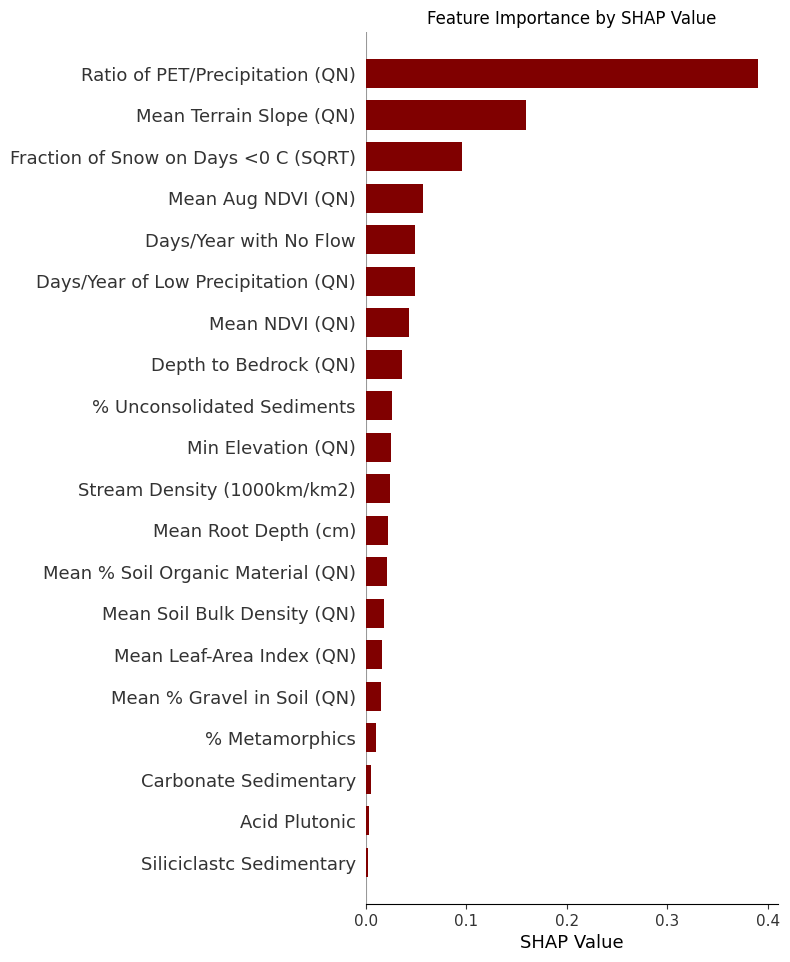

In [25]:
# SHAP Summary Plot (Bar)
plt.title("SHAP Feature Importance (Bar Plot)")
shap.summary_plot(shap_values, X_shap,
                  plot_type = "bar",
                  show = False,
                  color = 'maroon',
                 alpha = 0.5)
plt.xlabel('SHAP Value')
plt.title('Feature Importance by SHAP Value')

# Save figure
shap_bar_imp_path = os.path.join(BASE_DIR, 'xai', 'figures', 'XGBoost_shap_bar_imp.png')
plt.savefig(shap_bar_imp_path, dpi = 400)

# Show plot
plt.show()

#### Summary Plot (Dot)
The dot summary plot is similar to the bar, but each dot represents a specific prediction. The feature value relates directly to the features actual numerical value, while it's location on the x-axis denotes its effect on the model prediction.

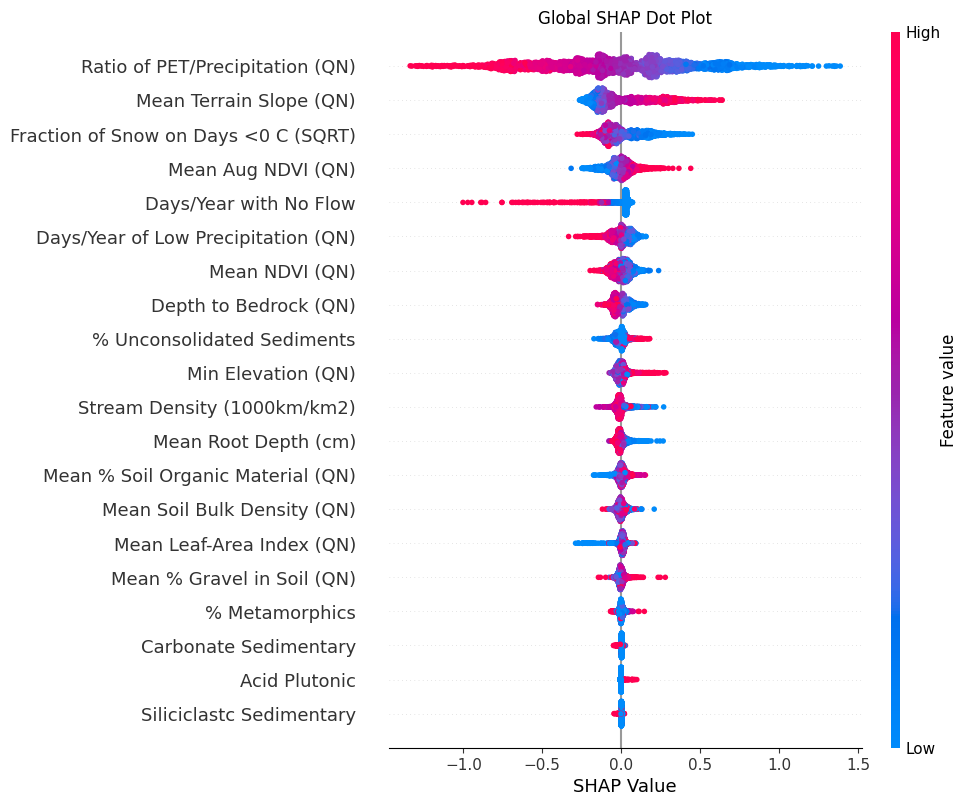

In [26]:
# SHAP Summary Plot Dot)
shap.summary_plot(shap_values, X_shap,
                  show = False,
                  plot_size=[10,8])
plt.xlabel('SHAP Value')
plt.title("Global SHAP Dot Plot")

# Save figure
shap_dot_path = os.path.join(BASE_DIR, 'xai', 'figures', 'XGBoost_shap_dot.png')
plt.savefig(shap_dot_path, dpi = 400)

# Show plot
plt.show()

#### Dependence Plots
We'll look at the top five features and use a dependence plot. These are still global (for the full test set).

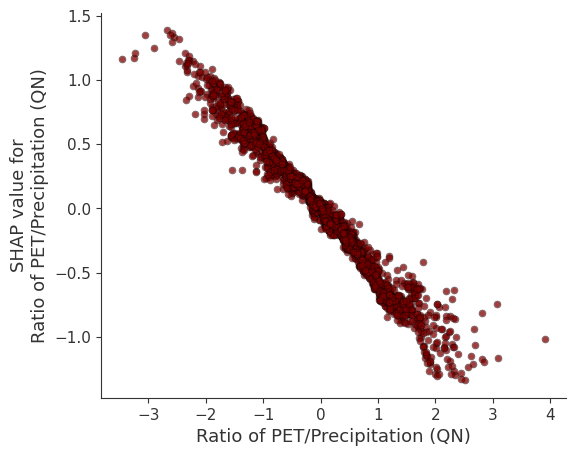

In [27]:
# PDP
shap.dependence_plot('Ratio of PET/Precipitation (QN)',
                     shap_values,
                     X_shap,
                    interaction_index = None,
                    color = 'maroon',
                     alpha = 0.5,
                    show = False)

plt.scatter(plt.gca().collections[0].get_offsets()[:, 0],
            plt.gca().collections[0].get_offsets()[:, 1],
            edgecolors='k',
            linewidths=0.5,
            alpha = 0.5,
            s = 25,
            color='maroon')

# Save figure
shap_pet_precip_path = os.path.join(BASE_DIR, 'xai', 'figures', 'XGBoost_shap_pet_precip.png')
plt.savefig(shap_pet_precip_path, dpi = 400)

# Show plot
plt.show()

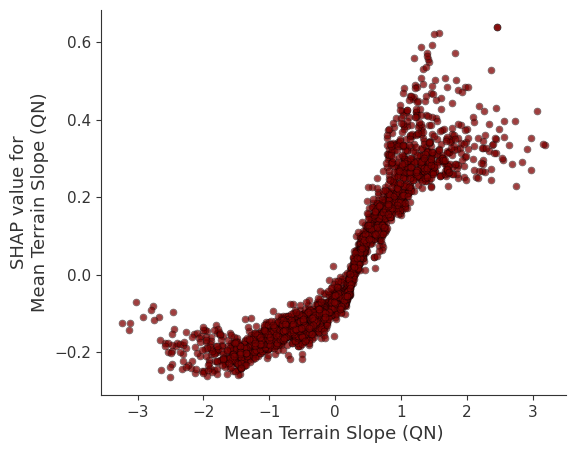

In [28]:
# PDP
shap.dependence_plot('Mean Terrain Slope (QN)',
                     shap_values,
                     X_shap,
                    interaction_index = None,
                    color = 'maroon',
                     alpha = 0.5,
                    show = False)

plt.scatter(plt.gca().collections[0].get_offsets()[:, 0],
            plt.gca().collections[0].get_offsets()[:, 1],
            edgecolors='k',
            linewidths=0.5,
            alpha = 0.5,
            s = 25,
            color='maroon')

# Save figure
shap_slope_path = os.path.join(BASE_DIR, 'xai', 'figures', 'XGBoost_shap_slope.png')
plt.savefig(shap_slope_path, dpi = 400)

# Show plot
plt.show()

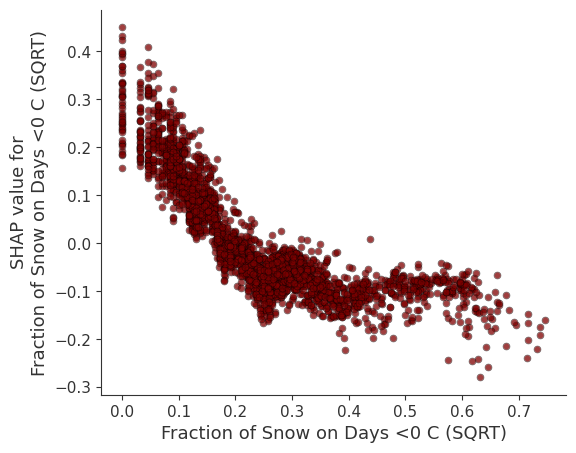

In [29]:
# PDP
shap.dependence_plot('Fraction of Snow on Days <0 C (SQRT)',
                     shap_values,
                     X_shap,
                    interaction_index = None,
                    color = 'maroon',
                     alpha = 0.5,
                    show = False)

plt.scatter(plt.gca().collections[0].get_offsets()[:, 0],
            plt.gca().collections[0].get_offsets()[:, 1],
            edgecolors='k',
            linewidths=0.5,
            alpha = 0.5,
            s = 25,
            color='maroon')

# Save figure
shap_snow_path = os.path.join(BASE_DIR, 'xai', 'figures', 'XGBoost_shap_snow.png')
plt.savefig(shap_snow_path, dpi = 400)

# Show plot
plt.show()

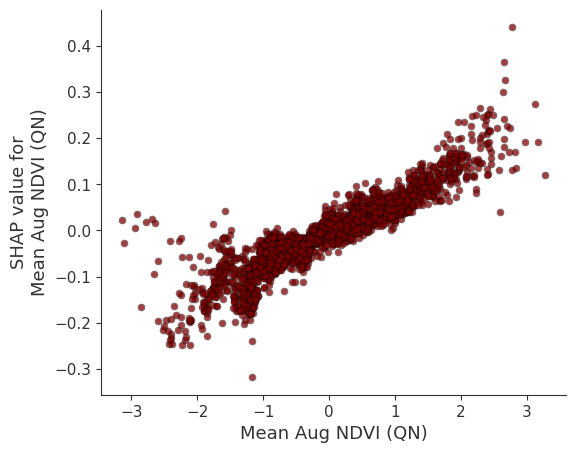

In [30]:
# PDP
shap.dependence_plot('Mean Aug NDVI (QN)',
                     shap_values,
                     X_shap,
                    interaction_index = None,
                    color = 'maroon',
                     alpha = 0.5,
                    show = False)

plt.scatter(plt.gca().collections[0].get_offsets()[:, 0],
            plt.gca().collections[0].get_offsets()[:, 1],
            edgecolors='k',
            linewidths=0.5,
            alpha = 0.5,
            s = 25,
            color='maroon')

# Save figure
shap_aug_ndvi_path = os.path.join(BASE_DIR, 'xai', 'figures', 'XGBoost_shap_aug_ndvi.png')
plt.savefig(shap_aug_ndvi_path, dpi = 400)

# Show plot
plt.show()

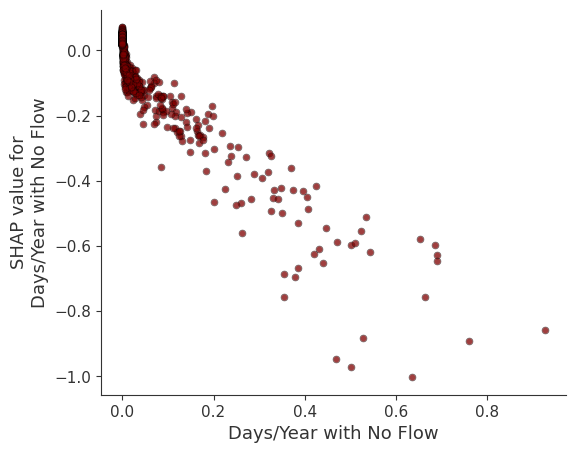

In [31]:
# PDP
shap.dependence_plot('Days/Year with No Flow',
                     shap_values,
                     X_shap,
                    interaction_index = None,
                    color = 'maroon',
                     alpha = 0.5,
                    show = False)

plt.scatter(plt.gca().collections[0].get_offsets()[:, 0],
            plt.gca().collections[0].get_offsets()[:, 1],
            edgecolors='k',
            linewidths=0.5,
            alpha = 0.5,
            s = 25,
            color='maroon')

# Save figure
shap_no_flow_path = os.path.join(BASE_DIR, 'xai', 'figures', 'XGBoost_shap_no_flow.png')
plt.savefig(shap_no_flow_path, dpi = 400)

# Show plot
plt.show()

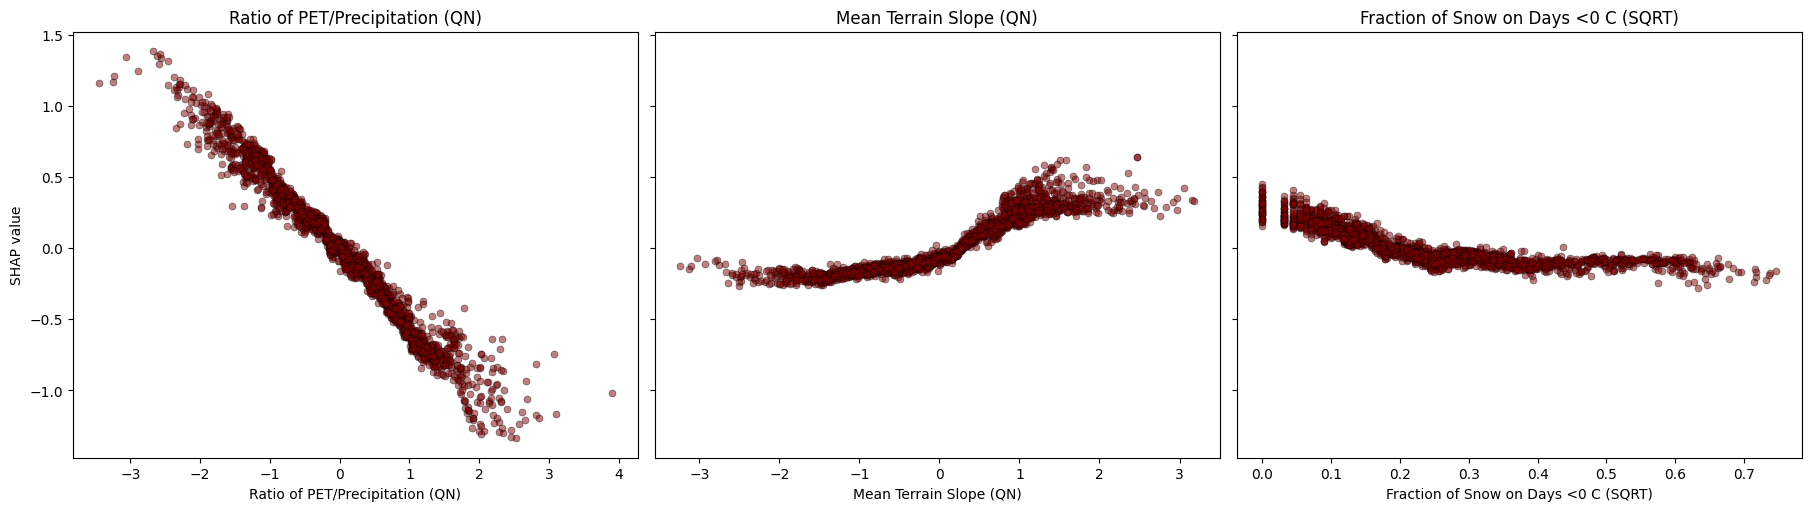

In [32]:
# List of features to plot
features = [
    'Ratio of PET/Precipitation (QN)',
    'Mean Terrain Slope (QN)',
    'Fraction of Snow on Days <0 C (SQRT)'
]

# Setup figure and axes
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True, constrained_layout=True)

for i, feature in enumerate(features):
    ax = axes[i]

    # Get SHAP values and feature values
    shap_feature_values = shap_values[:, X_shap.columns.get_loc(feature)]
    x_values = X_shap[feature].values

    # Scatter plot
    ax.scatter(x_values, shap_feature_values,
               edgecolors='k',
               linewidths=0.5,
               alpha=0.5,
               s=25,
               color='maroon')

    ax.set_title(feature, fontsize=12)
    ax.set_xlabel(feature)
    if i == 0:
        ax.set_ylabel("SHAP value")

# Save combined figure
shap_slope_path = os.path.join(BASE_DIR, 'xai', 'figures', 'XGBoost_shap_dependence_grid.png')
plt.savefig(shap_slope_path, dpi=400)
plt.show()